In [1]:
from IPython.display import display
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score
import category_encoders as ce


In [2]:
traindata=pd.read_csv("Traindata.csv")
X = traindata.drop(['class'], axis=1)
y = traindata['class']

In [3]:
def encoding(X_train,X_test):
    encoder = ce.OneHotEncoder(cols=['age', 'job', 'marital', 'education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome'])
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)
    return X_train,X_test

In [4]:
def printTree(clf,X_train):
    cls=['yes','no']
    dot_data = tree.export_graphviz(clf, out_file=None, 
                              feature_names=X_train.columns, 
                              class_names=cls,
                              filled=True, rounded=True,  
                              special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png('Decisiontree.png')



In [5]:
def printOutput(X_test_original,prediction,algoNum):
    X_test_original['Will subscribe a term deposit(yes/no)']=prediction
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    pd.set_option('display.precision', 3)
    if(algoNum==1):
        X_test_original.to_csv("DecisionTreeOutput.csv",index=False)
    else:
        X_test_original.to_csv("NavieBayesOutput.csv",index=False)

In [6]:
def printHeatMap(cm,algoNum):
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    if(algoNum==1):
        result_path = 'DecisionTree_HeatMap.png'
    else:
        result_path='NavieBayes_HeatMap.png'
    plt.savefig(result_path, dpi=400)

In [7]:
def ModelEvalution(y_test,prediction,algoNum):
    cm=confusion_matrix(y_test,prediction)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    true_positive_rate = TP / float(TP + FN)
    false_positive_rate = FP / float(FP + TN)
    true_negative_rate=TN / float(TN + FP)
    false_negative_rate=FN / float(FN + TP)
    specificity = TN / (TN + FP)
    if(algoNum==1):
        printHeatMap(cm,1)
    else:
        printHeatMap(cm,2)
    return [round(classification_accuracy,3),round(classification_error,3),precision,recall,f1_score,true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate]


In [8]:
def crossValidation_Score(clf,X_train,y_train):
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring='accuracy')
    return round(scores.mean(),3)


In [9]:
def ROC_Curve(clf,X_test,y_test,algoNum):
    y_pred1 = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label = 'yes')
    ROC_AUC = roc_auc_score(y_test, y_pred1)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.xlabel('False Positive Rate (Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    if(algoNum==1):
        plt.title('ROC curve for Decision Classifier for Predicting Subscription')
        result_path = 'DecisionTree_ROCcurve.png'
    else:
        plt.title('ROC curve for NavieBayes Classifier for Predicting Subscription')
        result_path='NavieBayes_ROCcurve.png'
    plt.savefig(result_path, dpi=400)
    return ROC_AUC

    

In [10]:
def print_classification_report(y_test,prediction,algoNum):
    if(algoNum==1):
        print("Classification Report of Decision Tree Algorithm:\n",classification_report(y_test,prediction))
    else:
        print("Classification Report of Navie Bayes Algorithm:\n",classification_report(y_test,prediction))

In [11]:
def Decisiontree():
    X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=10)
    X_test_original=X_test.copy(deep=False)
    X_train_original=X_train.copy(deep=False)
    X_train,X_test=encoding(X_train,X_test)
    clf = DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=4,random_state=10) #max_depth is maximum number of levels in the tree
    clf.fit(X_train,y_train)
    printTree(clf,X_train)
    prediction=clf.predict(X_test)
    printOutput(X_test_original,prediction,1) 
    evalList=ModelEvalution(y_test,prediction,1)
    evalList.append(crossValidation_Score(clf,X_train,y_train))
    evalList.append(ROC_Curve(clf,X_test,y_test,1))
    evalList.insert(0,round(clf.score(X_train,y_train),3))
    evalList.insert(1,round(clf.score(X_test, y_test),3)) 
    print_classification_report(y_test,prediction,1)
    return evalList

C:\Users\Krupal\anaconda3\envs\dtree\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


Classification Report of Decision Tree Algorithm:
               precision    recall  f1-score   support

          no       0.89      0.99      0.94       796
         yes       0.56      0.13      0.21       109

    accuracy                           0.88       905
   macro avg       0.73      0.56      0.57       905
weighted avg       0.85      0.88      0.85       905



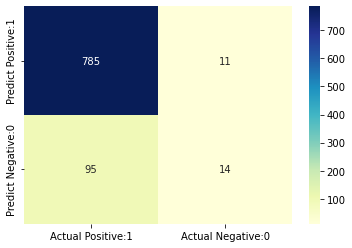

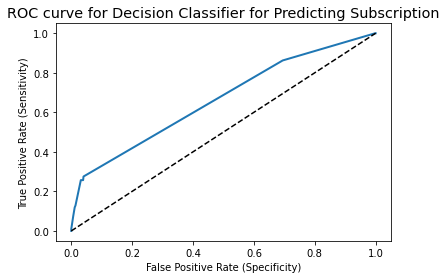

In [12]:
dtlist=Decisiontree()

In [13]:
def NaiveBayes():
    X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=10)
    X_test_original=X_test.copy(deep=False)
    X_train_original=X_train.copy(deep=False)
    X_train,X_test=encoding(X_train,X_test)
    nv = BernoulliNB()
    nv.fit(X_train, y_train)
    y_pred = nv.predict(X_test)
    printOutput(X_test_original,y_pred,2)
    evalList=ModelEvalution(y_test,y_pred,2)
    evalList.append(crossValidation_Score(nv,X_train,y_train))
    evalList.append(ROC_Curve(nv,X_test,y_test,2))
    evalList.insert(0,round(nv.score(X_train,y_train),3))
    evalList.insert(1,round(nv.score(X_test, y_test),3))
    print_classification_report(y_test,y_pred,2) 
    return evalList

C:\Users\Krupal\anaconda3\envs\dtree\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


Classification Report of Navie Bayes Algorithm:
               precision    recall  f1-score   support

          no       0.90      0.99      0.94       796
         yes       0.70      0.17      0.28       109

    accuracy                           0.89       905
   macro avg       0.80      0.58      0.61       905
weighted avg       0.87      0.89      0.86       905



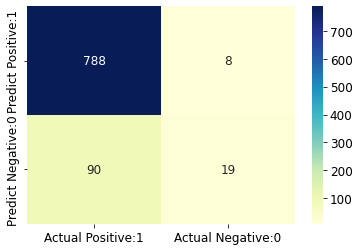

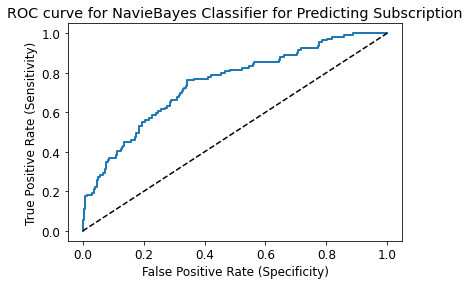

In [14]:
nbList=NaiveBayes()


In [15]:

print("Comparing the perfomance of two Algorithms\n")
data = {'Decision Tree Algorithm':dtlist,'Navie Bayes Algorithm':nbList}
headers=["Training set score","Test set score","Classification Accuracy Score","Classification Error", "Precision", "Recall", "F1 Score","True Positive Rate","False Positive Rate","True Negative Rate","False Negative Rate","10 fold Cross Validation Score","ROC_AUC"] 
print(pd.DataFrame(data, headers))

Comparing the perfomance of two Algorithms

                                Decision Tree Algorithm  Navie Bayes Algorithm
Training set score                       0.898                   0.909        
Test set score                           0.883                   0.892        
Classification Accuracy Score            0.883                   0.892        
Classification Error                     0.117                   0.108        
Precision                                0.986                   0.990        
Recall                                   0.892                   0.897        
F1 Score                                 0.937                   0.941        
True Positive Rate                       0.892                   0.897        
False Positive Rate                      0.440                   0.296        
True Negative Rate                       0.560                   0.704        
False Negative Rate                      0.108                   0.103        
10 fold 